In [20]:
import scipy as sp
import time
import numpy as np 
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy import table
from astropy.table import join
import pandas as pd
from tabulate import tabulate
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split 
import pickle

# Specify the version of the catalog and the folder with the input/output files

# Loading the Farmer version of the COSMOS2020 Cat
catversion1 = 'Farmer'  
dir_in1 ='/Users/yokisalcedo/Desktop/Emission-Line-Galaxy-Target-Selection/data/'  
dir_out1 = '/Users/yokisalcedo/Desktop/data/' # the directory where the output of this notebook will be stored
# Upload the main catalogue
cat = table.Table.read(dir_in1+'COSMOS2020_{}_jan_processed.fits'.format(catversion1),format='fits',hdu=1).to_pandas()

#All possible non-redundant colors are listed below:
#u: ug ,ur ,ui ,uz , uy
#g: gr, gi, gz, gy
#r: ri, rz, ry
#i: iz, iy
#z: zy

ug = cat['CFHT_u_MAG'] - cat['HSC_g_MAG'] 
ur = cat['CFHT_u_MAG'] - cat['HSC_r_MAG']
ui = cat['CFHT_u_MAG'] - cat['HSC_i_MAG']
uz = cat['CFHT_u_MAG'] - cat['HSC_z_MAG'] 
uy = cat['CFHT_u_MAG'] - cat['HSC_y_MAG']
gr = cat['HSC_g_MAG'] - cat['HSC_r_MAG']
gi = cat['HSC_g_MAG'] - cat['HSC_i_MAG']
gz = cat['HSC_g_MAG'] - cat['HSC_z_MAG']
gy = cat['HSC_g_MAG'] - cat['HSC_y_MAG']
ri = cat['HSC_r_MAG'] - cat['HSC_i_MAG']
rz = cat['HSC_r_MAG'] - cat['HSC_z_MAG']
ry = cat['HSC_r_MAG'] - cat['HSC_y_MAG']
iz = cat['HSC_i_MAG'] - cat['HSC_z_MAG']
iy = cat['HSC_i_MAG'] - cat['HSC_y_MAG']
zy = cat['HSC_z_MAG'] - cat['HSC_y_MAG']
r = cat['HSC_r_MAG']
g = cat['HSC_g_MAG']
i = cat['HSC_i_MAG']
y = cat['HSC_y_MAG']
z = cat['HSC_z_MAG']

cat['ug']= ug
cat['ur']= ur
cat['ui']=ui
cat['uz']=uz
cat['uy']=uy
cat['gr']=gr
cat['gi']=gi
cat['gz']=gz
cat['gy']=gy
cat['ri']=ri
cat['rz']=rz
cat['ry']=ry
cat['iz']=iz
cat['iy']=iy
cat['zy']=zy
cat['HSC_r_MAG'] = r
cat['HSC_g_MAG'] = g
cat['HSC_i_MAG'] = i
cat['HSC_y_MAG'] = y
cat['HSC_z_MAG'] = z

colormaskx = np.logical_and.reduce((np.isfinite(cat['HSC_r_MAG']),
                                    np.isfinite(cat['photoz']),
                                    np.isfinite(cat['HSC_g_MAG']),np.isfinite(cat['HSC_i_MAG']),
                                    np.isfinite(cat['HSC_y_MAG']),np.isfinite(cat['CFHT_u_MAG']),
                                    np.isfinite(cat['HSC_z_MAG']),
                                    (np.logical_or(cat['HSC_g_MAG']< 24.5, cat['HSC_r_MAG']< 24.5))))

#Here we defind our narrow and broad zcut, all RFs and all colors
#(xalln, yn, zalln, galln), (xallb, yb, zallb , gallb )
zcutn = np.logical_and(cat['photoz'] > 1.05, cat['photoz'] < 1.45)
zcutb = np.logical_and(cat['photoz'] > 1.05, cat['photoz'] < 1.55)
xalln = cat.loc[colormaskx,['ug','ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy','HSC_r_MAG','HSC_i_MAG','HSC_y_MAG','HSC_z_MAG','CFHT_u_MAG', 'HSC_g_MAG']]
xallb = cat.loc[colormaskx,['ug','ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy','HSC_r_MAG','HSC_i_MAG','HSC_y_MAG','HSC_z_MAG','CFHT_u_MAG', 'HSC_g_MAG']]
zalln = cat['photoz'][colormaskx]
zallb = cat['photoz'][colormaskx]
galln = cat.loc[colormaskx,['HSC_g_MAG']]
gallb = cat.loc[colormaskx,['HSC_g_MAG']]
yn = zcutn[colormaskx]
yb = zcutb[colormaskx]
ralln = cat['HSC_r_MAG'][colormaskx]
rallb = cat['HSC_r_MAG'][colormaskx]
rialln = cat['HSC_r_MAG'][colormaskx] - cat['HSC_i_MAG'][colormaskx]

#Function to make overplots of histograms with cuts 
def zhistcuts(data, prob, handcut, handcutiz, vlinemin = 1.05, vlinemax = 1.55, xlabel = 'LePhare Photometric Redshift', histtype = 'step', xlim=(0, 2), **kwargs):
    fig, ax = plt.subplots( figsize=(8, 6))
    ax.set_xlim(xlim)
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Count')
    ax.axvline(vlinemin,ls= '--', color='black')
    ax.axvline(vlinemax,ls= '--', color='black')
    ax.hist(data[prob], bins = np.linspace(0, 2, 100)  , histtype = histtype, color = 'red', label = 'RF Broad', alpha = 0.5, **kwargs)
    ax.hist(data[handcut], bins = np.linspace(0, 2, 100)  , histtype = histtype, color = 'grey', label = 'i-y/r-i cut', fill = True, alpha = 0.5, **kwargs)
    ax.hist(data[handcutiz], bins = np.linspace(0, 2, 100)  , histtype = histtype, color = 'lightblue', label = '+ i-z cut', fill = True, alpha = 0.5, **kwargs)
    ax.legend()
    
    return fig, ax
  

#Here, we split the data into training and testing sets
xallb_train, xallb_test, yb_train, yb_test, zallb_train, zallb_test, gallb_train, gallb_test, rallb_train, rallb_test = train_test_split(xallb, yb, zallb, gallb, rallb)
clfall_b = RandomForestClassifier()
# fitb = clfall_b.fit(xallb_train, yb_train)   
# pickle.dump(clfall_b, open('clfall_b.pkl', 'wb'))
pickled_clfall_b = pickle.load(open('/Users/yokisalcedo/Desktop/Emission-Line-Galaxy-Target-Selection/notebooks/clfall_b.pkl', 'rb'))
pickled_clfall_b.predict(xallb_test) 
pickled_clfall_b.predict_proba(xallb_test) 
pickled_clfall_b.predict_proba(xallb)

predallb = pickled_clfall_b.predict(xallb_test) 
proballb = pickled_clfall_b.predict_proba(xallb_test) 
proballb_full = pickled_clfall_b.predict_proba(xallb)
probmaskallb_full = proballb_full[:, 1] >= 0.025




/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 1.1.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


(<Figure size 800x600 with 1 Axes>,
 <AxesSubplot: xlabel='LePhare Photometric Redshift', ylabel='Count'>)

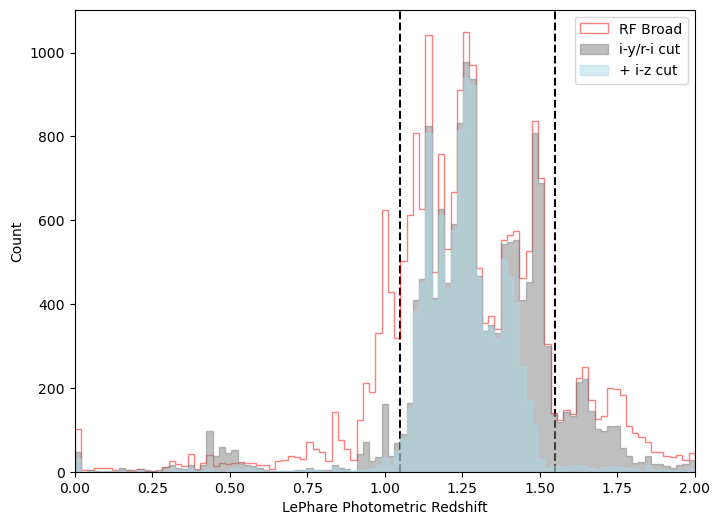

In [21]:


xallb = cat.loc[colormaskx,['ug','ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy','HSC_r_MAG','HSC_i_MAG','HSC_y_MAG','HSC_z_MAG','CFHT_u_MAG', 'HSC_g_MAG']]

proballb_full = pickled_clfall_b.predict_proba(xallb)
probmaskallb_full = proballb_full[:, 1] >= 0.025
iyri_cut = np.logical_and((xallb['iy'] > 0.35),(xallb['ri'] < xallb['iy'] - 0.1)) 
iz_cut = np.logical_and((xallb['iy'] > 0.35),(xallb['ri'] < xallb['iy'] - 0.1))
iz_cut &= (xallb['iz'] > 0.35)
photoz =  cat.loc[colormaskx,['photoz']]

#calling function to make hist overplots
zhistcuts(photoz, probmaskallb_full, iyri_cut, iz_cut)
    